### Fine-tuning for classification

#### 6.2 Preparing the dataset

In [151]:
import urllib.request
import zipfile
from pathlib import Path
import os

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Slipping download and extraction.")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    
    
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Slipping download and extraction.


In [152]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "Text"])

print(df.head())
print("Df length:", len(df))

  label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Df length: 5572


In [153]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [154]:
def create_balanced_dataset(df):
    spam_count = df["label"].value_counts()["spam"]
    
    ham_sample = df[df["label"] == "ham"].sample(spam_count, random_state=123)
    
    return pd.concat([ham_sample, df[df["label"] == "spam"]])

balanced_df = create_balanced_dataset(df)
print(balanced_df["label"].value_counts())
print(balanced_df.head())

label
ham     747
spam    747
Name: count, dtype: int64
     label                                               Text
4307   ham  Awww dat is sweet! We can think of something t...
4138   ham                             Just got to  &lt;#&gt;
4831   ham  The word "Checkmate" in chess comes from the P...
4461   ham  This is wishing you a great day. Moji told me ...
5440   ham      Thank you. do you generally date the brothas?


In [155]:
# df[df["label"] == "spam"]

In [156]:
print(balanced_df.head())

balanced_df["label"] = balanced_df["label"].map({
    "ham": 0,
    "spam": 1
})

balanced_df.head()

     label                                               Text
4307   ham  Awww dat is sweet! We can think of something t...
4138   ham                             Just got to  &lt;#&gt;
4831   ham  The word "Checkmate" in chess comes from the P...
4461   ham  This is wishing you a great day. Moji told me ...
5440   ham      Thank you. do you generally date the brothas?


,label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [157]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    train_end = int(len(df) * train_frac)
    val_end = train_end + int(len(df) * validation_frac)
    
    return df[:train_end], df[train_end: val_end], df[val_end:]

print(balanced_df.head())

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

print(train_df)
print(validation_df)
print(test_df)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

      label                                               Text
4307      0  Awww dat is sweet! We can think of something t...
4138      0                             Just got to  &lt;#&gt;
4831      0  The word "Checkmate" in chess comes from the P...
4461      0  This is wishing you a great day. Moji told me ...
5440      0      Thank you. do you generally date the brothas?
      label                                               Text
0         0                Dude how do you like the buff wind.
1         0  Tessy..pls do me a favor. Pls convey my birthd...
2         1  Reminder: You have not downloaded the content ...
3         1  Got what it takes 2 take part in the WRC Rally...
4         1  Shop till u Drop, IS IT YOU, either 10K, 5K, £...
...     ...                                                ...
1040      1  4mths half price Orange line rental & latest c...
1041      1  Thanks for the Vote. Now sing along with the s...
1042      1  IMPORTANT INFORMATION 4 ORANGE USER 0796XX

#### 6.3 创建数据加载器

In [158]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

end_text_token = "<|endoftext|>"

print(tokenizer.encode(end_text_token, allowed_special={end_text_token}))

[50256]


In [159]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self.__longest_encoded_length()
        else:
            self.max_length = max_length
            
        self.encoded_texts = [
            text[:self.max_length] for text in self.encoded_texts
        ]
        
        self.encoded_texts = [
            text + [pad_token_id] * (self.max_length - len(text)) for text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        return (
            torch.tensor(self.encoded_texts[index], dtype=torch.long),
            torch.tensor(self.data.iloc[index]["label"], dtype=torch.long)
        )
        
    
    def __len__(self):
        return len(self.data)
    
    def __longest_encoded_length(self):
        max_length = 0
        for text in self.encoded_texts:
            length = len(text)
            if max_length < length:
                max_length = length
                
        return max_length
    
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [160]:
validation_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

print(len(validation_dataset))
print(len(test_dataset))

149
300


In [161]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

print(f"Train loader length: {len(train_loader)}")
print(f"Validation loader length: {len(val_loader)}")
print(f"Test loader length: {len(test_loader)}")

for input_batch, target_batch in train_loader:
    pass
print(input_batch.shape)
print(target_batch.shape)

Train loader length: 130
Validation loader length: 19
Test loader length: 38
torch.Size([8, 120])
torch.Size([8])


#### 6.4 初始化带有预训练权重的模型

In [162]:
import json

CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASIC_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASIC_CONFIG.update(model_configs[CHOOSE_MODEL])

formatted_basic_config = json.dumps(BASIC_CONFIG, indent=4)

print(formatted_basic_config)

{
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": true,
    "emb_dim": 768,
    "n_layers": 12,
    "n_heads": 12
}


In [163]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(' ')[-1].lstrip("(").rstrip(")")

print(model_size)

setting, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASIC_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

124M
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/checkpoint
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/encoder.json
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/hparams.json) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/hparams.json
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/model.ckpt.data-00000-of-00001
Fil

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [164]:
from previous_chapters import generate_text_simple, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"

output_token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(text_1, tokenizer=tokenizer),
    max_new_tokens=100,
    context_size=BASIC_CONFIG["context_length"]
)

print(token_ids_to_text(output_token_ids, tokenizer=tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work.

The second step is to understand the importance of your work.

The third step is to understand the importance of your work.

The fourth step is to understand the importance of your work.

The fifth step is to understand the importance of your work.

The sixth step is to understand the importance of your work.

The seventh step is to understand the importance of your work.


In [165]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASIC_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


#### 6.5 添加分类头

In [166]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [167]:
# 为了使模型准备好微调，我们首先要冻结模型，即将所有层设置为不可训练
for params in model.parameters():
    params.requires_grad = False
    
torch.manual_seed(123)
# 需要分两类
num_classes = 2

model.out_head = torch.nn.Linear(
    in_features=BASIC_CONFIG["emb_dim"],
    out_features=num_classes
)

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
    
for param in model.final_norm.parameters():
    param.requires_grad = True
    

In [168]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)

print("Inputs:", inputs)
print("Input shape:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Input shape: torch.Size([1, 4])


In [169]:
with torch.no_grad():
    outputs = model(inputs)

print(f"Outputs: {outputs}")
print(f"Output shape: {outputs.shape}")

Outputs: tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Output shape: torch.Size([1, 4, 2])


In [170]:
last_output = outputs[:, -1, :]
print(last_output)

tensor([[-3.5983,  3.9902]])


#### 6.6 计算分类损失和准确度

In [171]:
torch.set_printoptions(sci_mode=False)

probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)

label = torch.argmax(probas)

print(label.item())

tensor([[    0.0005,     0.9995]])
1


In [172]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)
                
            predicted_label = torch.argmax(logits[:, -1, :], dim=-1)
            
            num_examples += predicted_label.shape[0]
            
            correct_predictions += (
                (predicted_label == target_batch).sum().item()
            )

        else:
            break
        
    return correct_predictions / num_examples


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)

validation_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)

test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {validation_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [173]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    
    return total_loss / num_batches

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    validation_loss = calc_loss_loader(
        val_loader, model, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, model, device, num_batches=5
    )

print(f"Loss of train data {train_loss:.3f}")
print(f"Loss of validation data {validation_loss:.3f}")
print(f"Loss of test data {test_loss:.3f}")

Loss of train data 3.095
Loss of validation data 2.583
Loss of test data 2.322


#### 6.7 有监督的微调模型

In [174]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        
    model.train()
    
    return train_loss, val_loss
        

def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss}, Val loss {val_loss}")
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        
        print(f"Train acc {train_accuracy*100:.2f}%")
        print(f"Val acc {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

import time

start_time = time.time()

torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5


train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5
)     

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes:.2f} minutes")        



Ep 1 (Step 000000): Train loss 2.1533891201019286, Val loss 2.391910457611084
Ep 1 (Step 000050): Train loss 0.6170465469360351, Val loss 0.6371331214904785
Ep 1 (Step 000100): Train loss 0.5231327295303345, Val loss 0.5573773860931397
Train acc 70.00%
Val acc 72.50%
Ep 2 (Step 000150): Train loss 0.5605329751968384, Val loss 0.48856871128082274
Ep 2 (Step 000200): Train loss 0.41897510886192324, Val loss 0.3966239333152771
Ep 2 (Step 000250): Train loss 0.4089108556509018, Val loss 0.3531010925769806
Train acc 82.50%
Val acc 85.00%
Ep 3 (Step 000300): Train loss 0.33341473937034605, Val loss 0.32036882638931274
Ep 3 (Step 000350): Train loss 0.3400189206004143, Val loss 0.3061771184206009
Train acc 90.00%
Val acc 90.00%
Ep 4 (Step 000400): Train loss 0.1363363966345787, Val loss 0.20014243721961975
Ep 4 (Step 000450): Train loss 0.15311819091439247, Val loss 0.13223406225442885
Ep 4 (Step 000500): Train loss 0.22239615246653557, Val loss 0.13655952289700507
Train acc 100.00%
Val acc 9

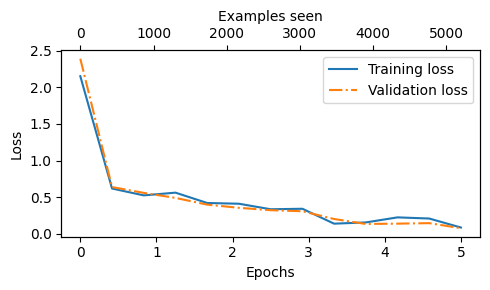

In [175]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

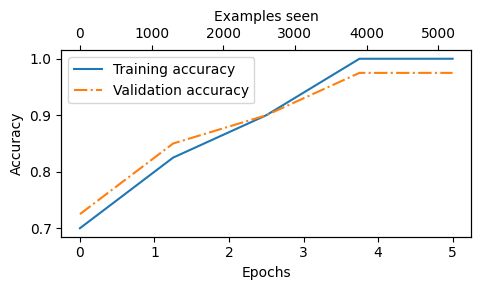

In [176]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [177]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


#### 6.8 使用大语言模型作为垃圾消息分类器

In [178]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
     
    input_ids += [pad_token_id] * (max_length - len(input_ids))
     
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
     
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]

    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"
         
        

In [179]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [180]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [181]:
torch.save(model.state_dict(), "review_classifier.pth")

In [182]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>